In [1]:
%autoreload 2


In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer
from src.fitness_features_by_category import FEATURE_CATEGORIES, PREDICATE_ROLE_FILLER_PATTERN_DICT, COUNTING_FEATURES_PATTERN_DICT

2023-09-11 13:17:29 - ast_utils - DEBUG    - Using cache folder: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache
2023-09-11 13:17:29 - src.ast_utils - DEBUG    - Using cache folder: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache


In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl.gz'))
print(len(real_game_texts), len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


2023-09-11 13:17:38 - src.ast_utils - INFO     - Loading from cache file: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache/interactive-beta-cache.pkl.gz
2023-09-11 13:17:39 - src.ast_utils - INFO     - Finished loading cache file: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache/interactive-beta-cache.pkl.gz


98 100352 1024.0


In [4]:
def extract_game_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    index = game_name[first_dash + 1:second_dash] if second_dash != -1 else game_name[first_dash + 1:]
    return int(index)


def extract_negative_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    if second_dash == -1:
        return -1
    
    third_dash = game_name.find('-', second_dash + 1)
    index = game_name[second_dash + 1:third_dash]
    return int(index)


fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')

# fitness_df = fitness_df.assign(real=fitness_df.real.astype('int'), game_index=fitness_df.game_name.apply(extract_game_index), 
#                                negative_index= fitness_df.game_name.apply(extract_negative_index), fake=~fitness_df.real.astype('int'))
# fitness_df = fitness_df.sort_values(by=['fake', 'game_index', 'negative_index'], ignore_index=True).reset_index(drop=True)
# fitness_df.drop(columns=['Index', 'fake', 'game_index', 'negative_index'], inplace=True)
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl.gz']


,Index,src_file,game_name,domain_name,original_game_name,real,variables_defined_all,variables_defined_incorrect_count,variables_used_all,variables_used_incorrect_count,...,ast_ngram_constraints_n_4_score,ast_ngram_constraints_n_5_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,0.0,1,0.0,...,0.968605,0.979319,0.964286,0.973077,0.976571,0.978192,0.919430,0.960971,0.998704,1.000000
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,0.0,1,0.0,...,0.974280,0.978391,0.959478,0.966184,0.977509,0.978958,0.899454,0.915154,0.965182,0.973559
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,0.0,1,0.0,...,0.946566,0.972470,0.000000,0.000000,0.000000,0.000000,0.851207,0.904668,0.948186,0.955972
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,0.0,1,0.0,...,0.986871,0.980256,0.000000,0.000000,0.000000,0.000000,0.919430,0.960971,0.998704,1.000000
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,0.0,1,0.0,...,0.983288,0.979510,0.000000,0.000000,0.000000,0.000000,0.964678,0.971974,0.973129,0.963587


In [6]:
# USE_BINARIZED_FEATURES_MODEL = True

# if USE_BINARIZED_FEATURES_MODEL:
#     model_path = '../models/cv_binarized_model_2023_01_20.pkl.gz'
#     data_df = binarized_df
# else:
#     model_path = '../models/cv_fitness_model_2023_01_20.pkl.gz'
#     data_df = filtered_fitness_df
from latest_model_paths import LATEST_FITNESS_FUNCTION_DATE_ID, LATEST_SPECIFIC_OBJECTS_FITNESS_FUNCTION_DATE_ID
# model_date_id = LATEST_FITNESS_FUNCTION_DATE_ID
# model_date_id = LATEST_SPECIFIC_OBJECTS_FITNESS_FUNCTION_DATE_ID
model_date_id = 'full_features_no_in_data_all_L1_categories_minimal_counting_2023_09_11'
data_df = fitness_df
cv_energy_model, feature_columns = utils.load_model_and_feature_columns(model_date_id)
print(len(feature_columns))



100


In [7]:
full_tensor = utils.df_to_tensor(data_df, feature_columns)
if 'wrapper' in cv_energy_model.named_steps: cv_energy_model.named_steps['wrapper'].eval()
full_tensor_scores = cv_energy_model.transform(full_tensor).detach()

In [8]:
real_game_scores = full_tensor_scores[:, 0]

print(f'Real game scores: {real_game_scores.mean():.4f} ± {real_game_scores.std():.4f}, min = {real_game_scores.min():.4f}, max = {real_game_scores.max():.4f}')

negatives_scores = full_tensor_scores[:, 1:]
torch.quantile(negatives_scores.ravel(), torch.linspace(0, 1, 11))
print(f'20th percentile negative energy: {torch.quantile(negatives_scores.ravel(), 0.2)}')

Real game scores: -37.0615 ± 0.8245, min = -38.8537, max = -33.3864
20th percentile negative energy: -35.085811614990234


In [9]:
utils.evaluate_fitness_overall_ecdf(cv_energy_model, full_tensor)

-0.03538840523765504

<Figure size 400x400 with 0 Axes>

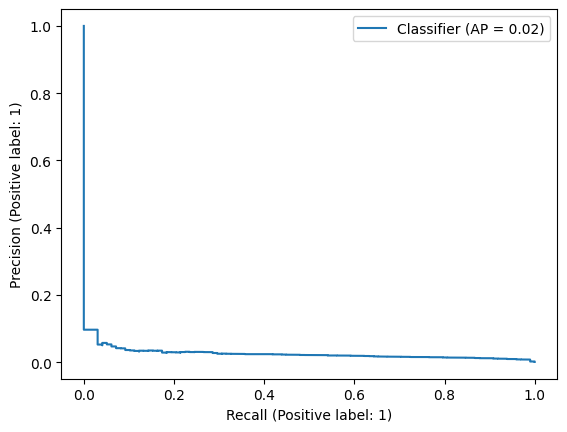

0.02484979061158592


In [10]:
from sklearn import metrics

positive_scores_numpy = real_game_scores.numpy().reshape(-1)
negative_scores_numpy = negatives_scores.numpy().reshape(-1)

n_positives = len(positive_scores_numpy)
n_negatives = len(negative_scores_numpy)

labels = np.concatenate([np.ones(n_positives), np.zeros(n_negatives)])
scores = np.concatenate([positive_scores_numpy, negative_scores_numpy]) * -1  # flipping the signs of the energies  # type: ignore


plt.figure(figsize=(4, 4))
metrics.PrecisionRecallDisplay.from_predictions(labels, scores)  # type: ignore
plt.legend(loc='best')
plt.show()

print(metrics.average_precision_score(labels, scores))


In [11]:
positives_mean, positives_variance = positive_scores_numpy.mean(), positive_scores_numpy.var()
negatives_mean, negatives_variance = negative_scores_numpy.mean(), negative_scores_numpy.var()

-1 * (positives_mean - negatives_mean) / np.sqrt(0.5 * (positives_variance + negatives_variance))

1.5722269504990838

In [12]:
steps = torch.linspace(0, 1, 11)
deciles = torch.quantile(negatives_scores.ravel(), steps)
print(steps)
print(f'Energy deciles: {deciles}')

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])
Energy deciles: tensor([-38.8537, -35.8821, -35.0858, -34.3146, -33.5985, -32.9519, -32.2223,
        -31.1863, -29.4903, -25.7578,   0.4491])


Weights mean: -0.2636, std: 2.6447, bias: 0.0100


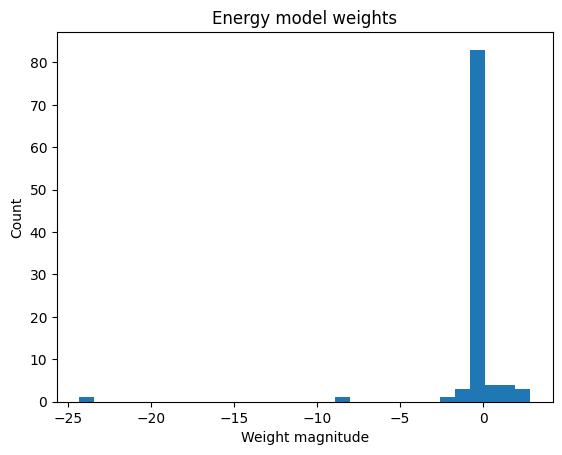

In [13]:
weights = cv_energy_model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
bias = cv_energy_model.named_steps['fitness'].model.fc1.bias.data.detach().squeeze()  # type: ignore
print(f'Weights mean: {weights.mean():.4f}, std: {weights.std():.4f}, bias: {bias:.4f}')

plt.hist(weights, bins=30)
plt.title('Energy model weights')
plt.xlabel('Weight magnitude')
plt.ylabel('Count')
plt.show()

In [15]:
K = 20
top_features = torch.topk(weights, K)
bottom_features = torch.topk(weights, K, largest=False)

lines = []

lines.append('### Features with largest negative weights (most predictive of real games):')
for i in range(K):
    lines.append(f'{i+1}. {feature_columns[bottom_features.indices[i]]} ({bottom_features.values[i]:.4f})')

lines.append('### Features with largest positive weights (most predictive of fake games):')
for i in range(K):
    lines.append((f'{i+1}. {feature_columns[top_features.indices[i]]} ({top_features.values[i]:.4f})'))

display(Markdown('\n'.join(lines)))


### Features with largest negative weights (most predictive of real games):
1. ast_ngram_full_n_5_score (-24.3013)
2. ast_ngram_constraints_n_5_score (-8.5157)
3. variables_used_all (-2.3820)
4. predicate_found_in_data_constraints_prop (-1.2435)
5. preferences_used_all (-1.0196)
6. num_preferences_defined_5 (-0.8488)
7. num_preferences_defined_1 (-0.3585)
8. setup_quantified_objects_used (-0.3269)
9. max_depth_setup_0 (-0.3091)
10. section_doesnt_exist_setup (-0.2561)
11. max_depth_constraints_1 (-0.2115)
12. node_count_setup_0 (-0.2115)
13. setup_objects_used (-0.1930)
14. node_count_constraints_3 (-0.1612)
15. node_count_terminal_0 (-0.0892)
16. max_depth_terminal_0 (-0.0892)
17. section_doesnt_exist_terminal (-0.0892)
18. pref_forall_pref_forall_correct_arity_correct (-0.0480)
19. node_count_constraints_1 (-0.0258)
20. node_count_scoring_3 (-0.0239)
### Features with largest positive weights (most predictive of fake games):
1. pref_forall_pref_forall_correct_types_incorrect (2.8327)
2. pref_forall_used_incorrect (2.7042)
3. repeated_variables_found (2.0414)
4. disjoint_seq_funcs_found (1.4888)
5. redundant_expression_found (1.2256)
6. node_count_constraints_4 (1.1180)
7. pref_forall_pref_forall_correct_arity_incorrect (1.0313)
8. two_number_operation_found (1.0062)
9. max_depth_constraints_3 (0.3218)
10. node_count_scoring_4 (0.3084)
11. node_count_setup_3 (0.1196)
12. max_depth_setup_3 (0.0760)
13. num_preferences_defined_3 (0.0564)
14. node_count_setup_2 (0.0263)
15. max_depth_terminal_2 (0.0215)
16. node_count_constraints_2 (0.0172)
17. starts_and_ends_once (0.0105)
18. max_depth_setup_1 (0.0104)
19. max_depth_scoring_1 (0.0064)
20. node_count_terminal_1 (0.0062)

In [14]:
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
quantile_index = 0

abs_weights = weights.abs()

for magnitude in torch.linspace(0,abs_weights.max(), 5000):
    n = torch.sum(abs_weights < magnitude).item()
    if n / len(weights) >= quantiles[quantile_index]:
        print(f'Approximately {quantiles[quantile_index] * 100}% ({n}, {n / len(weights) * 100:.2f}%) of the weights have magnitude < {magnitude:.4f}')
        quantile_index += 1

    if quantile_index >= len(quantiles):
        break

Approximately 10.0% (51, 51.00%) of the weights have magnitude < 0.0049
Approximately 25.0% (61, 61.00%) of the weights have magnitude < 0.0097
Approximately 50.0% (63, 63.00%) of the weights have magnitude < 0.0146
Approximately 75.0% (75, 75.00%) of the weights have magnitude < 0.0924
Approximately 90.0% (90, 90.00%) of the weights have magnitude < 1.0354
Approximately 95.0% (95, 95.00%) of the weights have magnitude < 2.0417
Approximately 99.0% (99, 99.00%) of the weights have magnitude < 8.5169


In [ ]:
from src.fitness_features_by_category import *


def print_weights_summary_by_category(model_weights: torch.Tensor, all_feature_columns: typing.List[str], return_lines: bool = False):
    abs_weights = model_weights.abs()
    sorted_feature_names = [t[1] for t in sorted([(abs_weights[i], all_feature_columns[i]) for i in range(len(all_feature_columns))], key=lambda x: x[0], reverse=True)]

    lines = []
    all_assigned_features = set()

    for category, features in FEATURE_CATEGORIES.items():
        category_feature_list = []
        for feature in features:
            if isinstance(feature, re.Pattern):
                category_feature_list.extend([f for f in feature_columns if feature.match(f)])

            else:
                category_feature_list.append(feature)

        all_assigned_features.update(category_feature_list)
        
        mean_abs_weight = np.mean([abs_weights[feature_columns.index(feature)] for feature in category_feature_list])
        sum_abs_weight = np.sum([abs_weights[feature_columns.index(feature)] for feature in category_feature_list])
        mean_sorted_index = np.mean([sorted_feature_names.index(feature) for feature in category_feature_list])
        prefix = f'For category {category} with {len(category_feature_list)} features'
        line = f'{prefix:54} | mean abs weight is {mean_abs_weight:5.2f} | sum abs weight is {sum_abs_weight:6.2f} | mean sorted index is {mean_sorted_index:6.2f}'
        if return_lines:
            lines.append(line)
        else:
            print(line)

    unassigned_features = [f for f in feature_columns if f not in all_assigned_features]
    if len(unassigned_features) > 0:
        print(f'Unassigned features: {unassigned_features}')

    if return_lines:
        return lines


In [ ]:
l1_model, _ = utils.load_model_and_feature_columns('full_features_no_in_data_all_L1_2023_08_29')

In [ ]:
MODEL_NAMES = ['Baseline', 'L1']
models = [cv_energy_model, l1_model]

for model_name, model in zip(MODEL_NAMES, models):
    display(Markdown(f'### For model {model_name}'))
    print_weights_summary_by_category(model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze(), feature_columns)
    

In [ ]:
utils.plot_energy_histogram(cv_energy_model, full_tensor)

In [ ]:
utils.plot_energy_histogram(l1_model, full_tensor)

In [ ]:
def print_mean_weight_by_category_pattern(model_weights: torch.Tensor, model_feature_columns: typing.List[str], 
                                          patterns: typing.Dict[str, re.Pattern], top_k: int = 3, prefix_width: int = 40,
                                          sort_by: str = 'mean_abs_weight'):
    
    abs_weights = model_weights.abs()
    lines_and_weights = []
    for name, pattern in patterns.items():
        feature_indices = [i for i, feature in enumerate(model_feature_columns) if pattern.match(feature)]
        if len(feature_indices) == 0:
            continue
        mean_abs_weight = abs_weights[feature_indices].mean().item()
        max_abs_weight = abs_weights[feature_indices].max().item()
        k = top_k
        if k > len(feature_indices):
            k = len(feature_indices)
        mean_top_k_abs_weight = abs_weights[feature_indices].topk(k).values.mean().item()
        prefix = f'For "{name}" features'.ljust(prefix_width)
        line = f'{prefix} | {len(feature_indices):2} features | mean weight = {mean_abs_weight:2.3f} | mean top {k} weights = {mean_top_k_abs_weight:2.3f} | max weight = {max_abs_weight:2.3f}'
        if sort_by == 'mean_abs_weight':
            sort_key = mean_abs_weight
        elif sort_by == 'mean_top_k_abs_weight':
            sort_key = mean_top_k_abs_weight
        elif sort_by == 'max_abs_weight':
            sort_key = max_abs_weight
        else:
            raise ValueError(f'Unknown sort_by value {sort_by}')
        
        lines_and_weights.append((line, sort_key))

    lines_and_weights.sort(key=lambda x: x[1], reverse=True)
    for line, _ in lines_and_weights:
        print(line)



def print_top_features_by_category(model_weights: torch.Tensor, model_feature_columns: typing.List[str], category: str, k: int = 10):
    category = category.lower()
    if category not in FEATURE_CATEGORIES:
        raise ValueError(f'Category {category} not found')
    
    category_features = []
    for category_feature_or_pattern in FEATURE_CATEGORIES[category]:
        if isinstance(category_feature_or_pattern, re.Pattern):
            category_features.extend([f for f in model_feature_columns if category_feature_or_pattern.match(f)])
        else:
            category_features.append(category_feature_or_pattern)

    sorted_features = sorted([(model_weights[i], model_feature_columns[i]) for i in range(len(model_feature_columns))], key=lambda x: x[0], reverse=False)
    sorted_category_features = [f for f in sorted_features if f[1] in category_features]

    lines = []

    lines.append(f'### {category.capitalize()} features with largest negative weights:')
    for i in range(k):
        lines.append(f'{i+1}. {sorted_category_features[i][1]} ({sorted_category_features[i][0]:.4f})')

    lines.append(f'### {category.capitalize()} features with largest positive weights:')
    for i in range(k):
        lines.append(f'{i+1}. {sorted_category_features[-(i + 1)][1]} ({sorted_category_features[-(i + 1)][0]:.4f})')

    display(Markdown('\n'.join(lines)))


def get_model_weights(model):
    return model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()


In [ ]:
with_counting_dates_and_names = [
    ('2023_09_05', 'fitness_sweep_full_features_no_in_data_all_L1_categories_with_counting'),
    ('2023_09_07_1', 'fitness_sweep_full_features_no_in_data_all_L1_categories_with_role_filler'),  # I mucked up the names here
    ('2023_09_07', 'fitness_sweep_full_features_no_in_data_all_L1_categories_with_role_filler'), # I mucked up the names here
]

with_counting_final_model_date_ids = [
    'full_features_no_in_data_all_L1_categories_with_counting_2023_09_05',
    'full_features_no_in_data_all_L1_categories_with_role_filler_seed_42_2023_09_07', # I mucked up the names here
    'full_features_no_in_data_all_L1_categories_with_role_filler_seed_66_2023_09_07' # I mucked up the names here
]

# for model_identifier in with_counting_dates_and_names:
for model_identifier in with_counting_final_model_date_ids:
    # display(Markdown(f'## {name}'))
    if isinstance(model_identifier, tuple):
        date_id, name = model_identifier
        current_cv_data = utils.load_data(date_id, 'data/fitness_cv', name)
        current_model = current_cv_data['cv'].best_estimator_
        current_feature_columns = current_cv_data['feature_columns']

    else:
        current_model, current_feature_columns = utils.load_model_and_feature_columns(model_identifier)
    # print_top_features_by_category(get_model_weights(l1_with_counting_cv_data['cv'].best_estimator_), l1_with_counting_cv_data['feature_columns'], 'counting', k=10)

    print_mean_weight_by_category_pattern(
        get_model_weights(current_model),
        current_feature_columns, COUNTING_FEATURES_PATTERN_DICT,
        sort_by='mean_abs_weight',
    )
    print()

In [ ]:
with_role_filler_dates_and_names = [
    ('2023_09_05', 'fitness_sweep_full_features_no_in_data_all_L1_categories_with_role_filler'),
    ('2023_09_07_1', 'fitness_sweep_full_features_no_in_data_all_L1_categories_with_counting'),  # I mucked up the names here
    ('2023_09_07', 'fitness_sweep_full_features_no_in_data_all_L1_categories_with_counting'), # I mucked up the names here
]

with_role_filler_final_model_date_ids = [
    'full_features_no_in_data_all_L1_categories_with_role_filler_2023_09_05',
    'full_features_no_in_data_all_L1_categories_with_counting_seed_42_2023_09_07', # I mucked up the names here
    'full_features_no_in_data_all_L1_categories_with_counting_seed_66_2023_09_07' # I mucked up the names here
]

# for model_identifier in with_role_filler_dates_and_names:
for model_identifier in with_role_filler_final_model_date_ids:
    # display(Markdown(f'## {name}'))
    if isinstance(model_identifier, tuple):
        date_id, name = model_identifier
        current_cv_data = utils.load_data(date_id, 'data/fitness_cv', name)
        current_model = current_cv_data['cv'].best_estimator_
        current_feature_columns = current_cv_data['feature_columns']

    else:
        current_model, current_feature_columns = utils.load_model_and_feature_columns(model_identifier)
    # print_top_features_by_category(get_model_weights(l1_with_counting_cv_data['cv'].best_estimator_), l1_with_counting_cv_data['feature_columns'], 'counting', k=10)

    print_mean_weight_by_category_pattern(
        get_model_weights(current_model),
        current_feature_columns, PREDICATE_ROLE_FILLER_PATTERN_DICT,
        sort_by='mean_abs_weight',
    )
    print()

## Looking at comparing the models on the negatives from the test set

In [ ]:
no_reg_sweep_data = utils.load_data('2023_08_29', 'data/fitness_cv', 'fitness_sweep_full_features_no_in_data_all')
print(no_reg_sweep_data.keys())
no_reg_test_scores = no_reg_sweep_data['cv'].best_estimator_.transform(no_reg_sweep_data['test_tensor'])
no_reg_test_real_game_scores = no_reg_test_scores[:, 0]
no_reg_test_negatives_scores = no_reg_test_scores[:, 1:]

no_reg_argsort = torch.argsort(no_reg_test_negatives_scores.ravel())
no_reg_position_to_index = torch.zeros_like(no_reg_argsort)
no_reg_position_to_index[no_reg_argsort] = torch.arange(len(no_reg_argsort))

no_reg_indices_with_better_negative = set(torch.where((no_reg_test_negatives_scores < no_reg_test_real_game_scores[:, None, :]).ravel())[0].numpy())
print(len(no_reg_indices_with_better_negative))



l1_sweep_data = utils.load_data('2023_08_29', 'data/fitness_cv', 'fitness_sweep_full_features_no_in_data_all_L1')
l1_test_scores = l1_sweep_data['cv'].best_estimator_.transform(l1_sweep_data['test_tensor'])
l1_test_real_game_scores = l1_test_scores[:, 0]
l1_test_negatives_scores = l1_test_scores[:, 1:]

l1_argsort = torch.argsort(l1_test_negatives_scores.ravel())
l1_position_to_index = torch.zeros_like(l1_argsort)
l1_position_to_index[l1_argsort] = torch.arange(len(l1_argsort))

l1_indices_with_better_negative = set(torch.where((l1_test_negatives_scores < l1_test_real_game_scores[:, None, :]).ravel())[0].numpy())
print(len(l1_indices_with_better_negative))

In [ ]:
utils.plot_energy_histogram(
    no_reg_sweep_data['cv'], 
    no_reg_sweep_data['train_tensor'], 
    no_reg_sweep_data['test_tensor'],
    histogram_title_note='no regularization')

utils.plot_energy_histogram(
    l1_sweep_data['cv'],
    l1_sweep_data['train_tensor'],
    l1_sweep_data['test_tensor'],
    histogram_title_note='L1 regularization')

In [ ]:
better_negative_both = no_reg_indices_with_better_negative.intersection(l1_indices_with_better_negative)
better_negative_l1_only = l1_indices_with_better_negative.difference(no_reg_indices_with_better_negative)
better_negative_no_reg_only = no_reg_indices_with_better_negative.difference(l1_indices_with_better_negative)

print(f'Both: {len(better_negative_both)}, L1 only: {len(better_negative_l1_only)}, No reg only: {len(better_negative_no_reg_only)}')

In [ ]:
index_diffs = no_reg_position_to_index - l1_position_to_index
index_diffs.topk(10, largest=False)

In [ ]:
utils.evaluate_energy_contributions(cv_energy_model, full_tensor, 987, 
        feature_columns, full_tensor, real_game_texts, regrown_game_1024_texts, display_features_diff=False, min_display_threshold=0.001)
    


In [ ]:
utils.evaluate_energy_contributions(l1_model, full_tensor, 987, 
        feature_columns, full_tensor, real_game_texts, regrown_game_1024_texts, display_features_diff=False, min_display_threshold=0.001)
    


In [ ]:
l1_categories_sweep_data = utils.load_data('2023_09_01', 'data/fitness_cv', 'fitness_sweep_full_features_no_in_data_all_L1_categories')

In [ ]:
utils.visualize_cv_outputs(
    l1_categories_sweep_data['cv'],
    l1_categories_sweep_data['train_tensor'],
    l1_categories_sweep_data['test_tensor']
)

